In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from fredapi import Fred
from statsmodels.tsa.arima.model import ARIMA
import seaborn as sns
from sklearn.metrics import mean_squared_error

fred = Fred(api_key="388e4633f23c88b89679b89794f572ed")
from tqdm import tqdm

import warnings

warnings.filterwarnings("ignore")

In [52]:
# loans = fred.get_series("CCLACBW027SBOG").rename("loans")
loans = pd.read_csv('consumerloans_clean.csv', index_col=0, parse_dates=True).rename(columns={"consumerloans": "loans"})
claims = fred.get_series("ICSA").rename('claims')  # Weekly
eff_funds = fred.get_series("FF").rename('eff_funds')  # Weekly
deposits = fred.get_series("DPSACBW027SBOG").rename('deposits')  # Weekly

arimax_df = pd.DataFrame(loans)
for s in [eff_funds, deposits]:
    arimax_df = pd.merge_asof(arimax_df, s, left_index=True, right_index=True)
arimax_df[['eff_funds_l1', 'deposits_l1']] = arimax_df[['eff_funds', 'deposits']].shift(1).bfill()
arimax_df['deposits_l1_log_ret'] = np.log(arimax_df['deposits_l1']).diff().bfill()

In [53]:
arimax_df

,loans,eff_funds,deposits,eff_funds_l1,deposits_l1,deposits_l1_log_ret
date,,,,,,
2000-06-28,551.643510,6.53,3576.1524,6.53,3576.1524,0.000000
2000-07-05,554.377885,6.85,3625.4808,6.53,3576.1524,0.000000
2000-07-12,553.241385,6.44,3613.4882,6.85,3625.4808,0.013699
2000-07-19,554.903785,6.50,3619.9306,6.44,3613.4882,-0.003313
2000-07-26,554.138385,6.50,3639.3521,6.50,3619.9306,0.001781
...,...,...,...,...,...,...
2024-03-13,1053.400000,5.33,17535.5968,5.33,17494.1022,0.002918
2024-03-20,1054.565700,5.33,17568.9661,5.33,17535.5968,0.002369
2024-03-27,1053.803300,5.33,17645.4336,5.33,17568.9661,0.001901


In [54]:
p=q=range(7)
arimax_models = np.empty((len(p), len(q)), dtype=object)
arimax_results = np.empty((len(p), len(q)), dtype=object)
for ar_lags in tqdm(p):
    for ma_lags in q:
        arimax = ARIMA(
            arimax_df.loans,
            order=(ar_lags, 1, ma_lags),
            exog=arimax_df[['eff_funds_l1', 'deposits_l1_log_ret']],
        )
        arimax_models[ar_lags, ma_lags] = arimax
        arimax_results[ar_lags, ma_lags] = arimax.fit()
arimax_aics = np.array(list(map(lambda r: r.aic, arimax_results.flatten()))).reshape(
    len(p), len(q)
)
arimax_aics = pd.DataFrame(arimax_aics, index=p, columns=q)

100%|██████████| 7/7 [01:30<00:00, 12.95s/it]


In [55]:
arima_models = np.empty((len(p), len(q)), dtype=object)
arima_results = np.empty((len(p), len(q)), dtype=object)
for ar_lags in tqdm(p):
    for ma_lags in q:
        arima = ARIMA(
            arimax_df.loans,
            order=(ar_lags, 1, ma_lags),
        )
        arima_models[ar_lags, ma_lags] = arima
        arima_results[ar_lags, ma_lags] = arima.fit()
arima_aics = np.array(list(map(lambda r: r.aic, arima_results.flatten()))).reshape(
    len(p), len(q)
)
arima_aics = pd.DataFrame(arima_aics, index=p, columns=q)

100%|██████████| 7/7 [00:55<00:00,  7.89s/it]


In [56]:
arima_aics

,0,1,2,3,4,5,6
0,5893.474225,5857.960885,5854.390152,5853.715282,5772.339611,5760.109527,5761.850614
1,5852.367088,5768.527580,5768.448444,5767.951067,5761.692919,5729.581966,5727.998905
2,5847.725236,5768.700824,5769.659671,5769.924526,5763.631942,5729.860836,5596.662352
3,5831.802553,5766.594730,5766.124471,5578.820335,5582.036632,5770.371716,5694.317553
4,5744.447336,5738.904189,5604.636117,5571.499136,5581.114160,5569.702597,5562.405042
5,5735.151882,5735.806085,5577.167194,5562.305978,5562.787607,5585.242101,5592.741368
6,5733.936916,5735.145290,5579.902140,5579.455394,5555.516799,5591.362521,5590.088880


In [57]:
arimax_aics

,0,1,2,3,4,5,6
0,5880.769291,5843.588526,5840.658209,5841.210082,5762.263539,5746.363016,5747.916278
1,5838.230391,5758.072385,5756.959720,5755.992364,5749.394391,5719.249600,5715.484412
2,5835.165993,5757.382514,5757.967701,5757.920660,5751.374065,5718.711930,5592.782676
3,5820.714509,5754.242295,5753.390053,5560.694707,5562.441806,5553.461284,5535.360822
4,5731.653879,5724.820502,5584.799645,5554.650835,5563.607280,5551.502557,5544.442659
5,5719.649216,5719.377427,5561.200067,5550.735287,5545.278349,5567.758452,5570.297214
6,5716.515608,5717.726001,5558.935078,5558.648264,5536.007841,5574.421019,5567.884695


In [58]:
arima_aics.stack().idxmin()

(6, 4)

In [59]:
arimax_aics.stack().idxmin()

(3, 6)

In [78]:
exog_forecast = np.zeros((52,2))

In [79]:
exog_forecast[:,0] = np.linspace(5.33, 4, 52)

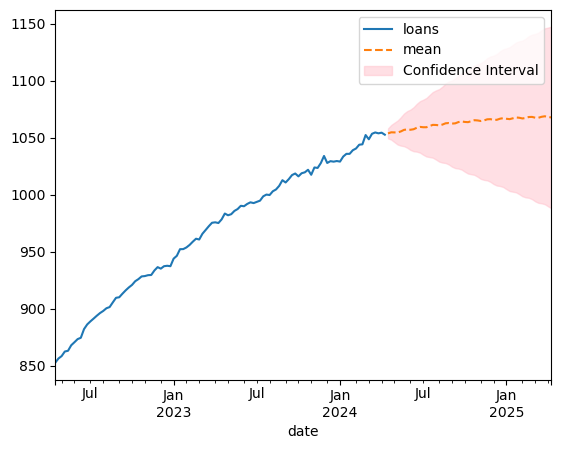

<AxesSubplot: >

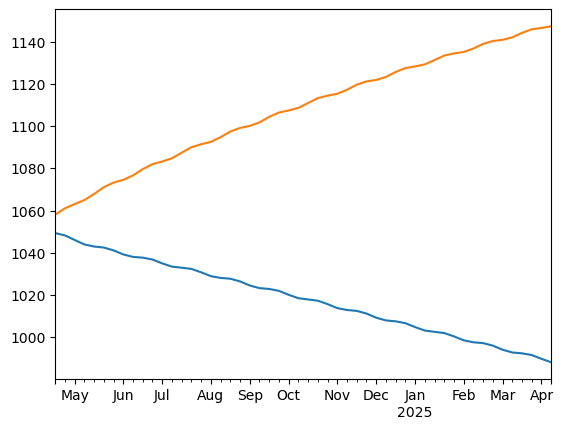

In [93]:
import numpy as np
loans[-104:].plot()
fc = arimax_results[3,6].get_forecast(steps=52, exog=exog_forecast).summary_frame()
fc['mean'].plot(linestyle='dashed')
plt.fill_between(fc.index, fc.mean_ci_upper, fc.mean_ci_lower, color='pink', alpha=0.5, label='Confidence Interval')
plt.legend()

# Show the plot
plt.show()

fc['mean_ci_lower'].plot()
fc['mean_ci_upper'].plot()

NameError: name 'plot_acf' is not defined